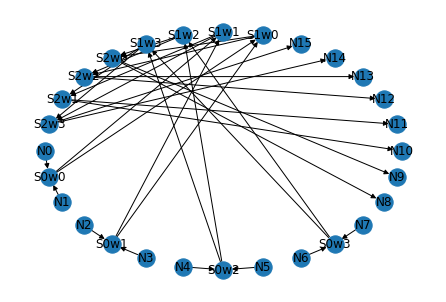

In [17]:
# Visualizer for generated network

####
# Requires: networkx, pygraphviz, and runs in an IPython environment (jupyter)
# Usage: run once to obtain a diagram of the network for given topology files (network.txt is updated)
#        and a DOT format output to visualize using other applications (eg. qvge / gephi / etc)
####

###################################
######      DEPENDENCIES     ######
###################################

# for running executable
import subprocess
# for representation and graph operations
# requires networkx
import networkx as nx
# for drawing
import matplotlib.pyplot as plt
# for easy errors
from os   import error

##############################
######     CONSTANTS    ######
##############################

# number of chars to ignore when parsing the lines
# "Links : <integer>"
# "NodeID: <identifier>"
IGN_LINKS  = 8
IGN_NODEID = 8

##############################
######      HELPERS     ######
##############################

# reads a file and returns its contents as string
def fileStr(f):
    # open the given file, read only
    f = open(f, 'r')
    # read into a string
    s = f.read()
    # free the lock on the file
    f.close()

    return s
## END DEF


# parses a single line in a topology-describing file
def parseTopologyLine(s):
    # split according to COMMAs
    s = s.split(',')
    # return X:str, n:int, m:int
    return (s[0], int(s[1]), int(s[2]))
## END DEF


# given a string with the contents of the generated network file
# parses it into a graph, with sanity checks along the way
def parseNetwork(s):
    # initialize graph
    G = nx.DiGraph()

    # currnode  : the current node from whom we're adding edges to others
    # edgecount : the number of edges remaining to be added from current node
    # encnodes  : the total number of nodes encountered in the input
    currnode  = 'error'
    edgecount = 0
    encnodes  = 0

    # parse each line
    for i in s.split('\n'):
        # Line style: NodeID: <identifier>
        # Action:     Add a node
        if len(i) == 0:
            continue
        if i[0] == 'N':
            # sanity check before starting with a new node
            if edgecount > 0:
                error(f'not enough edges for node: {currnode}, remaining: {edgecount}')

            # add node to graph
            G.add_node(i[IGN_NODEID:])
            # set currnode
            currnode = i[IGN_NODEID:]
            # increment encountered nodes count
            encnodes += 1

        # Line style: Links: <integer>
        # Action:     Set edge count
        elif i[1] == 'i':
            # count of edges
            edgecount = int(i[IGN_LINKS:])

        # Line style: L(<integer>): <identifier>
        # Action:     Add a directed edge
        elif i[1] == '(':
            # add a link
            G.add_edge(currnode, i.split(':')[1])
            # one less link remaining
            edgecount -= 1

        # Line style: *
        # Action:     ERROR
        else:
            # ERROR
            error('umm weird input: ' + i)
        
        # sanity check: don't add more edges than reported
        if edgecount < 0:
            error('too many edges for node: ' + currnode)
    ## END FOR

    # graph fully constructed
    return G
## END DEF


##############################
######      TESTING     ######
##############################

# run the executable, with topology input files from testdir
subprocess.run(["./generator.py"])

# we use networkx library to save time reimplementing directed graphs
# totalNodes are passed just as a sanity check
network1 = parseNetwork(fileStr("Network.txt"))

# draw the graph object (require an IPython environment)
nx.draw_shell(network1, with_labels=True)
# output in DOT format (requires pygraphviz)
nx.drawing.nx_agraph.write_dot(network1, "Out.txt")